In [14]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [15]:
def load_npy_float32(path: str) -> np.ndarray:
    """DatasetFolder loader: loads a .npy image saved as float32."""
    return np.load(path).astype(np.float32)

In [19]:
VAL_DIR = "processed/val"
CKPT_PATH = "logs\pneumonia/version_4/checkpoints/epochepoch=04-valaurocval/auroc=0.9130.ckpt"


val_transforms = transforms.Compose([
    transforms.ToTensor(),                 
    transforms.Normalize(mean=0.49, std=0.248),
])

val_dataset = torchvision.datasets.DatasetFolder(
    root=VAL_DIR,
    loader=load_npy_float32,
    extensions=("npy",),
    transform=val_transforms,
)
print("val samples:", len(val_dataset), "classes:", val_dataset.classes)

val samples: 2684 classes: ['0', '1']


In [20]:
class PneumoniaModel(pl.LightningModule):
    """ResNet18 adapted for 1-channel chest X-ray binary classification."""
    def __init__(self):
        super().__init__()
        backbone = torchvision.models.resnet18(weights=None)  
        backbone.conv1 = torch.nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        backbone.fc = torch.nn.Linear(512, 1)

        self.model = backbone
        self.feature_map = torch.nn.Sequential(*list(backbone.children())[:-2])

    def forward(self, x: torch.Tensor):
        # x: (B,1,224,224)
        feats = self.feature_map(x)                
        pooled = self.model.avgpool(feats)          
        pooled = torch.flatten(pooled, 1)          
        logits = self.model.fc(pooled)             
        return logits, feats

In [22]:
# Load trained weights
model = PneumoniaModel.load_from_checkpoint(CKPT_PATH, strict=False).to(device)
model.eval()

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [23]:
@torch.no_grad()
def compute_cam(model: PneumoniaModel, img: torch.Tensor):
    """Compute CAM heatmap for a single image tensor (1,H,W)."""
    img = img.to(device)
    logits, feats = model(img.unsqueeze(0))  
    prob = torch.sigmoid(logits)[0, 0].detach().cpu()

    # fc weight: (1,512) for binary
    w = model.model.fc.weight[0].detach()    
    _, c, h, w_hw = feats.shape              

    cam = torch.einsum("c,bchw->bhw", w, feats)[0]  

    # Normalize to [0,1] for visualization
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = cam.detach().cpu()
    return cam, float(prob)

In [24]:
def show_cam(img: torch.Tensor, cam: torch.Tensor, prob: float):
    """Overlay CAM on the original image."""
    img_np = img[0].cpu().numpy()
    cam_up = transforms.functional.resize(cam.unsqueeze(0), img_np.shape)[0].numpy()

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_np, cmap="bone")
    ax[0].set_title("X-ray")
    ax[0].axis("off")

    ax[1].imshow(img_np, cmap="bone")
    ax[1].imshow(cam_up, alpha=0.5, cmap="jet")
    ax[1].set_title(f"CAM overlay (p={prob:.3f})")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

label: 1 | prob(pneumonia): 0.9453538656234741


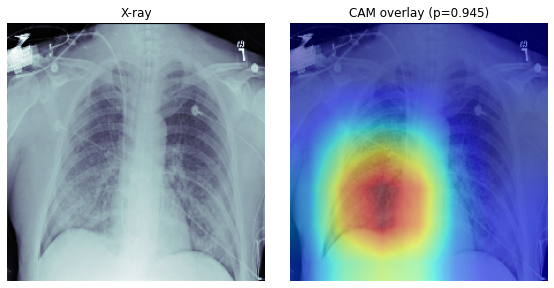

In [27]:
# Example: pick one validation sample
idx = -6
img, label = val_dataset[idx]
cam, prob = compute_cam(model, img)

print("label:", label, "| prob(pneumonia):", prob)
show_cam(img, cam, prob)